# Non-local means denoising

**Louis Martinez**

[Link to the paper](./Articles/nlmeans.pdf)

Implementation of NL-means denoising method from IMA207 lecture : __Patch based approaches for image processing__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

from skimage.io import imread, imsave, imshow
from skimage.util import random_noise

from tqdm import tqdm
from IPython.display import display

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 12

def compute_PSNR(i1, i2):
    """
    Compute PSNR between two images of same size.
    Assumes that i1 and i2 a 

    i1 : first input image
    i2 : second input image
    """
    i1 = (i1*255).astype(np.int16)
    i2 = (i2*255).astype(np.int16)

    diff = (i1-i2)**2
    eqm = np.mean(diff)

    MAX=255.
    return 20*np.log10(MAX/np.sqrt(eqm))

Shape of input image : (256, 256)


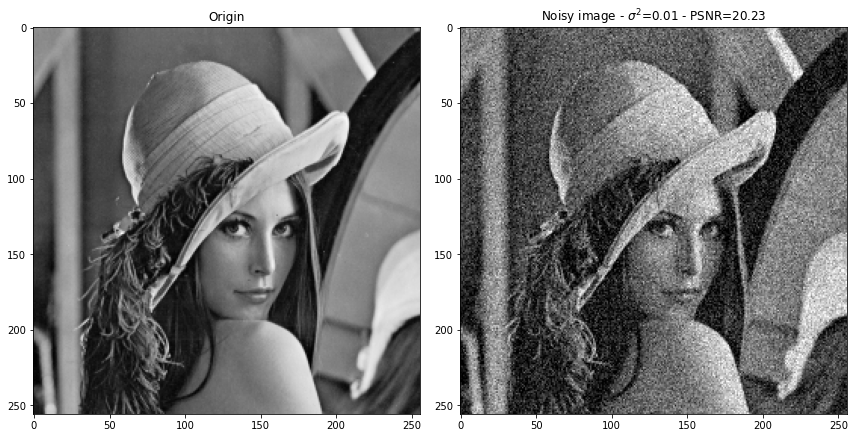

In [2]:
std = 0.1
var = std**2

im = imread('images/lena_petit.tif')/255
im_noise = random_noise(im, mode='gaussian', var=var)

fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(im)
ax[0].set_title('Origin')
ax[1].imshow(im_noise)
ax[1].set_title(rf'Noisy image - $\sigma^2$={var:.2f} - PSNR={compute_PSNR(im, im_noise):.2f}')
plt.tight_layout()

print(f'Shape of input image : {im.shape}')

---
## Theorical aspects

### Notations

- $u$ : original denoised image
- $v$ : noisy image
- $\hat{u}$ : reconstructed image
- $u(x)$ : value of pixel $x$ in original image
- $v(x)$ : value of pixel $x$ in noisy image
- $\hat{u}(x)$ : value of pixel $x$ n reconstructed image
- $V(x)$ : vector containing the value of all pixels in a patch centered on pixel $x$ (typical size around $3\times3$ or $9$ if flattened)
- $W(x)$ : window centered on $x$ (typical size $35\times35$)

### Main formulas

Dissimilarity measure between two patched centered on $x$ and $y$ :  
$$dissi(x,y)=\|V(x)-V(y)\|_2^2$$

Normalization coefficient of weights for each patch included in the window centered on $x$ :  
$$C(x)=\sum_{z\in W(x)} e^{-\frac{dissi(x,z)}{2h^2}}$$

Weight between patches centered on $x$ and $y$ :  
$$w(x,y)=e^{-\frac{dissi(x,y)}{2h^2}}$$

Estimated value of $u(x)$ :  
$$\hat{u}(x)=\frac{1}{C(x)}\sum_{y\in W(x)} w(x,y)v(y)$$

---
## Pixelwise implementation

The article deals with two ways of denoising an image using nl-means: a pixelwise and a patchwise approach.  
In this section we implement the first approach.

In [5]:
def compute_dissi(x, y):
    """
    Compute the dissimilarity measure between 2 patches
    Patches must have the same shape

    x : reference patch
    y : patch to be compared with x 
    """
    return np.sum((x-y)**2)/x.shape[0]**2

def compute_weight(x, y, h):
    """
    Compute weight between patches x and y

    x : reference patch
    y : current patch
    h : parameter such that the higher it is, the lower the weight
    """
    dissi = compute_dissi(x, y)
    return np.exp(-dissi/(2*h**2))


def nl_filter(im, ws, ps, h_dissi, stride=3):
    """
    Apply NL-means filter to an image

    im : image to which to apply the filter
    ws : size of the window centered on the current pixel to be reconstructed
    ps : size of the patch to be compared with the central patch of the window
    h_dissi : parameter for weight computation
    stride : parameter to accelerate the process by decreasing the number of tested patches
    """
    w, h = im.shape
    im_pad = np.pad(im, ws)
    res = np.zeros(im.shape)

    # Display progress bar
    with tqdm(total=w*h) as pbar:

        for i in range(w):
            for j in range(h):
                
                center = i+ws, j+ws # Center of the window
                ref = im_pad[center[0]-ps//2:center[0]+ps//2+1, center[1]-ps//2:center[1]+ps//2+1] # Patch centered on the central pixel

                C = 0  # Sum of weights for normalization
                prod = 0  # Product w(ref,patch)u(patch)
                for ii in range(i+ws//2,i+ws+ws//2,stride):
                    for jj in range(j+ws//2,j+ws+ws//2,stride):
                        patch = im_pad[ii-ps//2:ii+ps//2+1 , jj-ps//2:jj+ps//2+1]
                        
                        u = patch[ps//2,ps//2]
                        w = compute_weight(patch, ref, h_dissi)
                        
                        C += w
                        prod += w*u
                        
                new_u = prod/C
                res[i,j] = new_u
                pbar.update(1)
    

    return res


# TESING DIFFERENT HYPERPARAMETERS
ws_vals = [21, 35]
ps_vals = [3, 5]
h_vals = [.8*std, 1.*std, 1.5*std]

out_list = []
params_list = []

for ws, ps, h in itertools.product(ws_vals, ps_vals, h_vals):
    print(f'Computing with : ws={ws}, ps={ps}, h={h:.2f}')
    out_list.append(nl_filter(im_noise, ws, ps, h, stride=2))
    params_list.append((ws, ps, h))

Computing with : ws=21, ps=3, h=0.08


100%|██████████| 65536/65536 [01:11<00:00, 921.17it/s]


Computing with : ws=21, ps=3, h=0.10


100%|██████████| 65536/65536 [01:11<00:00, 912.00it/s]


Computing with : ws=21, ps=3, h=0.15


100%|██████████| 65536/65536 [01:16<00:00, 853.43it/s]


Computing with : ws=21, ps=5, h=0.08


100%|██████████| 65536/65536 [01:24<00:00, 771.90it/s]


Computing with : ws=21, ps=5, h=0.10


100%|██████████| 65536/65536 [01:25<00:00, 766.98it/s]


Computing with : ws=21, ps=5, h=0.15


100%|██████████| 65536/65536 [01:24<00:00, 776.10it/s]


Computing with : ws=35, ps=3, h=0.08


100%|██████████| 65536/65536 [04:03<00:00, 269.17it/s]


Computing with : ws=35, ps=3, h=0.10


100%|██████████| 65536/65536 [03:33<00:00, 307.40it/s]


Computing with : ws=35, ps=3, h=0.15


100%|██████████| 65536/65536 [03:18<00:00, 330.71it/s]


Computing with : ws=35, ps=5, h=0.08


100%|██████████| 65536/65536 [03:20<00:00, 327.09it/s]


Computing with : ws=35, ps=5, h=0.10


100%|██████████| 65536/65536 [03:42<00:00, 294.01it/s]


Computing with : ws=35, ps=5, h=0.15


100%|██████████| 65536/65536 [03:22<00:00, 323.40it/s]


---
## Testing the method

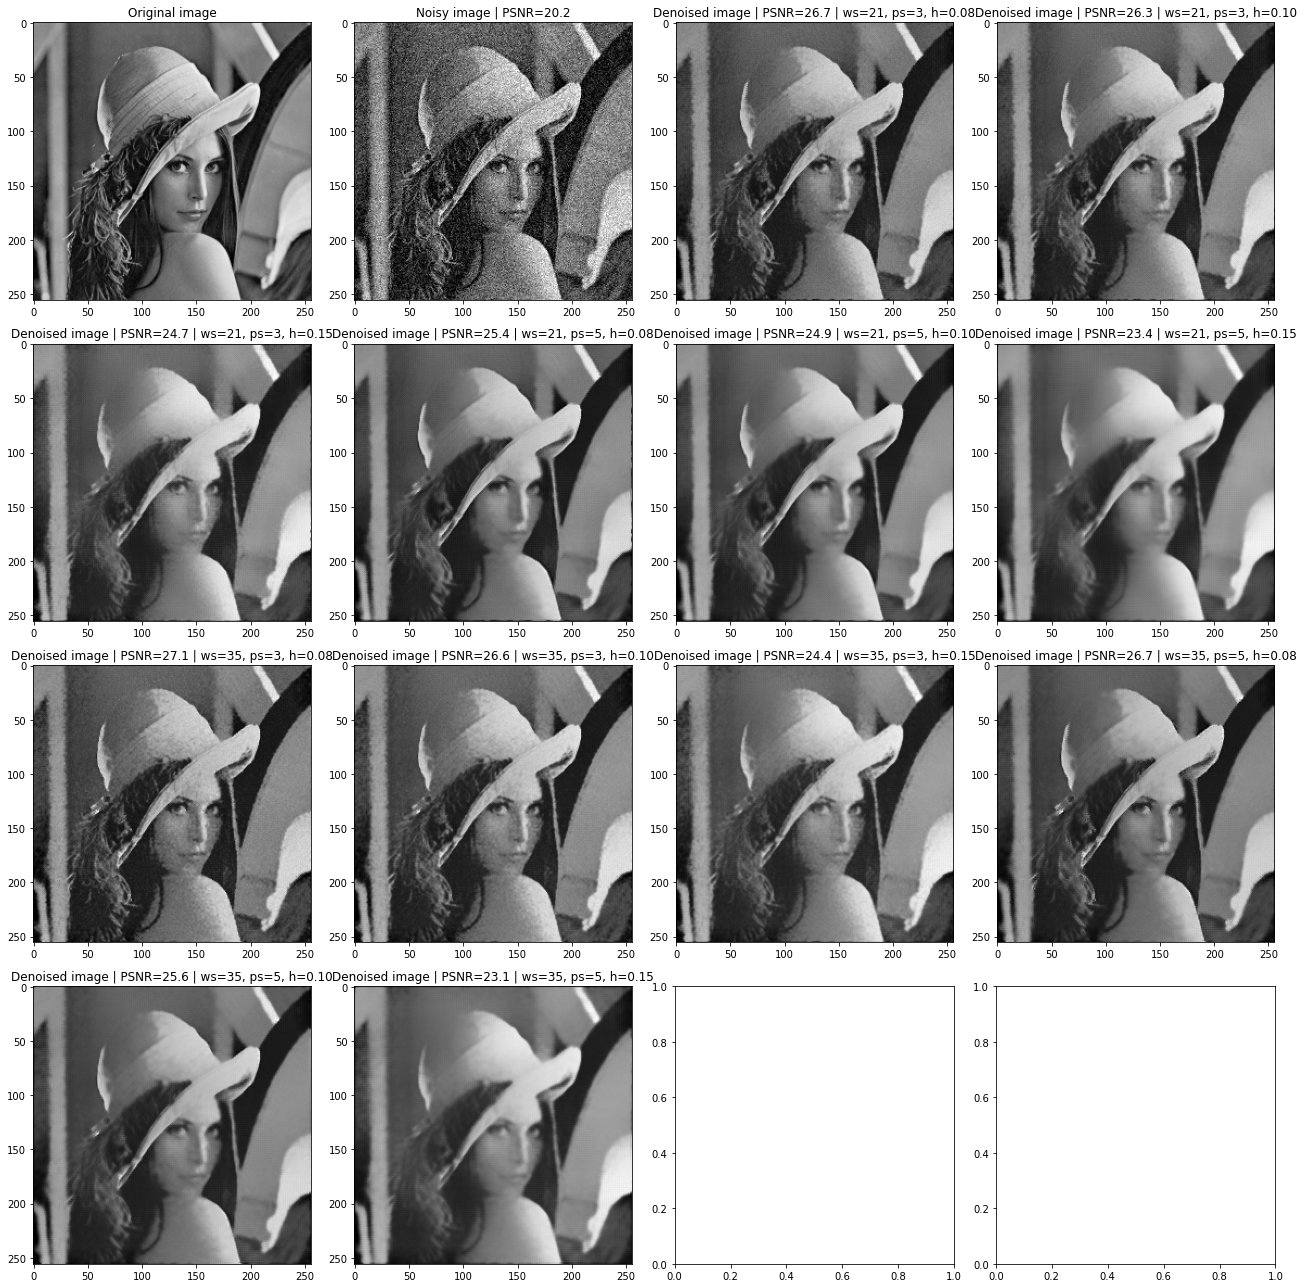

In [8]:
# DISPLAY THE RESULTS
fig, axes = plt.subplots(4,4, figsize=(18,18))
ax = axes.ravel()
ax[0].imshow(im)
ax[0].set_title('Original image')
ax[1].imshow(im_noise)
ax[1].set_title(f'Noisy image | PSNR={compute_PSNR(im, im_noise):.1f}')
for i in range(len(out_list)):
    ax[i+2].imshow(out_list[i])
    ax[i+2].set_title(f'Denoised image | PSNR={compute_PSNR(im, out_list[i]):.1f} | ws={params_list[i][0]}, ps={params_list[i][1]}, h={params_list[i][2]:.2f}')

plt.tight_layout()
plt.show()